In [1]:
max_seq_length = 2048
dtype = None
load_in_4bit = True


from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "results/fb15k/llama_True_True/checkpoint-18874", 
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
)
FastLanguageModel.for_inference(model)
from torch.utils.data import DataLoader

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/root/instructKGC/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.529 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [2]:
chat_prompt = """
### Instruction:
{}

### Input:
{}

### Response:
{}"""



In [3]:
EOS_TOKEN = tokenizer.eos_token 

def formatting_prompts_func(examples):
    instruction = "Predict with the help of the given context and related facts, the tail entity [mask] by filling in the sentence. Return only the tail entity."
    inputs       = examples["prompt"]
    outputs      = examples["completion"]
    texts = []
    for input, output in zip(inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = chat_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

In [4]:
from tqdm import tqdm


def compute_metrics(dataset, batch_size: int = 16):

    
    model.eval()  # Set model to evaluation mode
    hits_1 = 0
    hits_3 = 0
    hits_10 = 0
    mrr = 0 
    total = 0
   

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    for batch in tqdm(dataloader, desc=f"Evaluating"):
        prompts = batch['prompt']
        ground_truths = batch['completion']
        # Format and tokenize all elements of the batch
        formatted_prompts = [chat_prompt.format("", prompt, "") for prompt in prompts]
        inputs = tokenizer(
            formatted_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_seq_length
        ).to("cuda")
        # Generate predictions with top-k sampling
        outputs = model.generate(
            **inputs,
            max_length=max_seq_length,
            do_sample=True,
            top_k=50,  # Top-k sampling with k=50
            num_return_sequences=10,
        )
       

        # Decode the outputs
        decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        grouped_predictions = [decoded_outputs[i:i + 10] for i in range(0, len(decoded_outputs), 10)]

        # Compare each ground truth with its prediction
        for i in range(len(prompts)):
            pred_group = grouped_predictions[i]
            label = ground_truths[i]
            pred_group = [pred.split("### Response:")[1].strip().split(EOS_TOKEN)[0].strip().replace("### Response:", "").strip() for pred in pred_group]
            if label in pred_group[:3]: 
                hits_3 += 1    
            if label in pred_group[:10]:  
                    hits_10 += 1  
            if label == pred_group[0]:
                hits_1 += 1
            rank = next((i + 1 for i, pred in enumerate(pred_group[:10]) if pred == label), 0)
            mrr += 1 / rank if rank > 0 else 0
            total += 1
    del inputs, outputs, decoded_outputs, grouped_predictions
    torch.cuda.empty_cache()
    hits_at_1 = hits_1 / total if total > 0 else 0.0
    hits_at_3 = hits_3 / total if total > 0 else 0.0
    hits_at_10 = hits_10 / total if total > 0 else 0.0
    mrr_final = mrr / total if total > 0 else 0.
    return {"hits@1": hits_at_1, "hits@3": hits_at_3, "hits@10": hits_at_10, "mrr": mrr_final}


In [5]:
from datasets import Dataset
from utils import build_graph, data_loader, entity2id_codex, entity2id_fb15k, entity2id_yago, find_neighbor_with_same_relation, find_triplet_with_same_relation, generate_prompt, get_triplet, load_patterns



dataset = "fb15k"
filename = "lookup_files/updated_patterns_fb15k"
    

if dataset in ['codex', 'codex-m']:
    entities_dict, relations_dict = entity2id_codex()
elif dataset=='fb15k':
    entities_dict, relations_dict = entity2id_fb15k()
elif dataset=='yago':
    entities_dict, relations_dict = entity2id_yago()


df = data_loader(dataset,'test',entities_dict, relations_dict )

graph, _=build_graph(dataset, ['test'], entities_dict, relations_dict)


patterns = load_patterns(f"{filename}.txt")  
df['triplets'] = df.apply(lambda row: get_triplet(row, patterns, graph), axis=1)
df['neighbor_fact']= df.apply(lambda row:find_neighbor_with_same_relation(graph, row['head'], row['relation']), axis=1)
df['same_relation_fact']=df.apply(lambda row:find_triplet_with_same_relation(graph, row['head'], row['relation']), axis=1)
    
df['prompt'] = df.apply(generate_prompt,with_desc=True, with_context=True, axis=1)
    
dataset = Dataset.from_pandas(df.rename(columns={'tail': 'completion'})[['prompt', 'completion']], preserve_index=False)
dataset = dataset.map(formatting_prompts_func, batched = True,)



Map: 100%|██████████| 20466/20466 [00:00<00:00, 101638.26 examples/s]


In [6]:
print(compute_metrics(dataset, batch_size=16))

Evaluating:   0%|          | 2/1280 [00:32<5:40:56, 16.01s/it]
/root/instructKGC/venv/lib/python3.12/site-packages/unsloth/models/llama.py:1574: SyntaxWarning: invalid escape sequence '\ '
  f"   \\\   /|    GPU: {gpu_stats.name}. Max memory: {max_memory} GB. Platform: {platform_system}.\n"\
/root/instructKGC/venv/lib/python3.12/site-packages/unsloth/models/llama.py:1575: SyntaxWarning: invalid escape sequence '\_'
  f"O^O/ \_/ \\    Torch: {torch.__version__}. CUDA: {gpu_stats.major}.{gpu_stats.minor}. CUDA Toolkit: {torch.version.cuda}. Triton: {triton_version}\n"\
/root/instructKGC/venv/lib/python3.12/site-packages/unsloth/models/llama.py:1576: SyntaxWarning: invalid escape sequence '\ '
  f"\        /    Bfloat16 = {str(SUPPORTS_BFLOAT16).upper()}. FA [Xformers = {xformers_version}. FA2 = {HAS_FLASH_ATTENTION}]\n"\
/root/instructKGC/venv/lib/python3.12/site-packages/unsloth/models/llama.py:1724: SyntaxWarning: invalid escape sequence '\.'
  start = re.search('logger\.info\([\"\'].+

KeyboardInterrupt: 

In [10]:
print(compute_metrics(dataset, batch_size=16))

Evaluating: 100%|██████████| 1280/1280 [53:28<00:00,  2.51s/it] 

{'hits@1': 0.22730382097136714, 'hits@3': 0.2941463891331965, 'hits@10': 0.3819505521352487, 'mrr': 0.27128326655591295}


In [6]:
print(compute_metrics(dataset, batch_size=16))

Evaluating: 100%|██████████| 645/645 [33:43<00:00,  3.14s/it] 

{'hits@1': 0.3075356415478615, 'hits@3': 0.4180001939676074, 'hits@10': 0.5482494423431287}


In [1]:
from utils import entity2id_codex, pre_process, add_desc
entities_dict, relations_dict = entity2id_codex()


        
df_train= pre_process('codex-m','train',entities_dict, relations_dict)


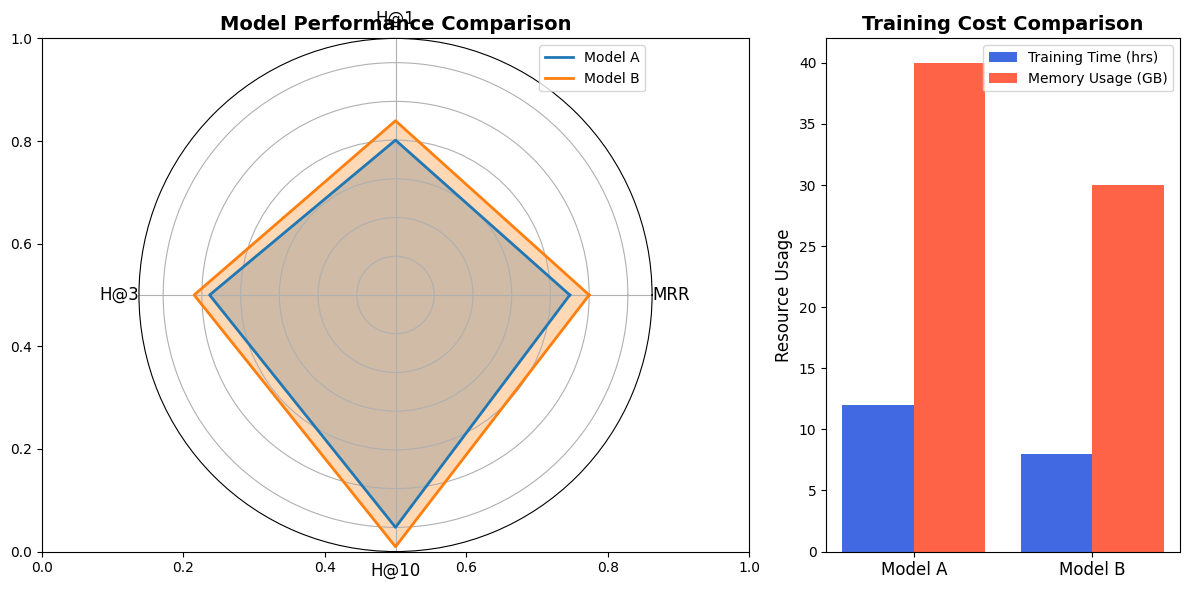

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the performance metrics
metrics = ["MRR", "H@1", "H@3", "H@10"]
num_metrics = len(metrics)

# Example performance values for two models
model_A_perf = [0.45, 0.40, 0.48, 0.60]  # Model A performance
model_B_perf = [0.50, 0.45, 0.52, 0.65]  # Model B performance

# Convert data to polar coordinates
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

# Close the data points for a full polygon
model_A_perf += model_A_perf[:1]
model_B_perf += model_B_perf[:1]

# Define training time & memory usage
models = ["Model A", "Model B"]
training_time = [12, 8]  # In hours
memory_usage = [40, 30]  # In GB

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [2, 1]})

### RADAR CHART (LEFT) ###
ax1.set_title("Model Performance Comparison", fontsize=14, fontweight="bold")
ax1 = plt.subplot(121, polar=True)
ax1.plot(angles, model_A_perf, label="Model A", linewidth=2, linestyle='solid')
ax1.fill(angles, model_A_perf, alpha=0.3)
ax1.plot(angles, model_B_perf, label="Model B", linewidth=2, linestyle='solid')
ax1.fill(angles, model_B_perf, alpha=0.3)
ax1.set_xticks(angles[:-1])
ax1.set_xticklabels(metrics, fontsize=12)
ax1.set_yticklabels([])
ax1.legend(loc="upper right")

### BAR CHART (RIGHT) ###
ax2.set_title("Training Cost Comparison", fontsize=14, fontweight="bold")
bar_width = 0.4
x = np.arange(len(models))

ax2.bar(x - bar_width/2, training_time, bar_width, label="Training Time (hrs)", color="royalblue")
ax2.bar(x + bar_width/2, memory_usage, bar_width, label="Memory Usage (GB)", color="tomato")

ax2.set_xticks(x)
ax2.set_xticklabels(models, fontsize=12)
ax2.set_ylabel("Resource Usage", fontsize=12)
ax2.legend()

# Show the combined plot
plt.tight_layout()
plt.show()



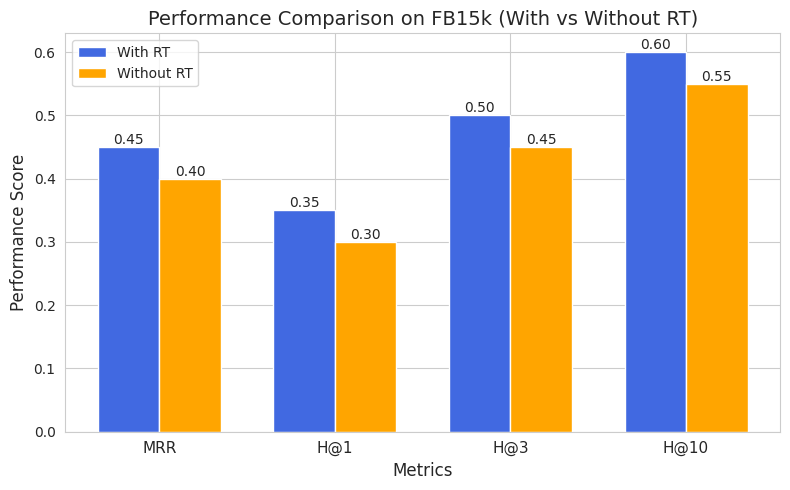

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the metrics
metrics = ["MRR", "H@1", "H@3", "H@10"]

# Performance values (example values, replace with actual results)
with_RT = [0.45, 0.35, 0.50, 0.60]  # Model with RT
without_RT = [0.40, 0.30, 0.45, 0.55]  # Model without RT

# Bar width and position
x = np.arange(len(metrics))
width = 0.35  

# Set style
sns.set_style("whitegrid")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars
bars1 = ax.bar(x - width/2, with_RT, width, label="With RT", color="royalblue")
bars2 = ax.bar(x + width/2, without_RT, width, label="Without RT", color="orange")

# Labels and title
ax.set_xlabel("Metrics", fontsize=12)
ax.set_ylabel("Performance Score", fontsize=12)
ax.set_title("Performance Comparison on FB15k (With vs Without RT)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend()

# Show values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [1]:

from unsloth import FastLanguageModel

from utils import  number_of_trainable_model_parameters
max_seq_length = 2048
dtype = None
load_in_4bit = True


model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    #model_name = "results/fb15k/llama_True_True",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)


llm = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print( number_of_trainable_model_parameters(llm))

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/root/instructKGC/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.2.
   \\   /|    GPU: NVIDIA RTX A6000. Max memory: 47.529 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


trainable model parameters: 41943040
all model parameters: 4582543360
percentage of trainable model parameters: 0.92%


In [1]:
from dataset import data_preprocess


dataset = 'fb15k'
patterns_file = 'updated_patterns_fb15k'
with_desc = True
with_ctxt = True
    
   
patterns_file =f"lookup_files/{patterns_file}.txt"

df = data_preprocess(dataset, 'test', with_desc, with_ctxt, patterns_file)

In [4]:
df

,head,relation,tail,description,triplets,neighbor_fact,same_relation_fact,prompt
0,Zürich,has monthly climate in,October,Zürich or Zurich is the largest city in Switze...,None,None,"(Washington, D.C., has monthly climate in, May)","Sentence: Head: Zürich, Relation: has monthly ..."
1,Autoharp,is a member of,Heart,The autoharp is a musical string instrument ha...,None,"(David Byrne, is a member of, Talking Heads)","(Dominican Republic, is a member of, United Na...","Sentence: Head: Autoharp, Relation: is a membe..."
2,Winnie the Pooh,released in,France,Winnie the Pooh is a 2011 American animated mu...,None,"(Brazil, released in, United Kingdom)","(Anonymous, released in, Italy)","Sentence: Head: Winnie the Pooh, Relation: rel..."
3,England,contains,Pontefract,England is a country that is part of the Unite...,"((England, has as a second-level division, Dev...","(West Sussex, contains, Worthing)","(Dominican Republic, contains, Santo Domingo)","Sentence: Head: England, Relation: contains, T..."
4,England,contains,Lancaster,England is a country that is part of the Unite...,"((England, has as a second-level division, Dev...","(West Sussex, contains, Worthing)","(Dominican Republic, contains, Santo Domingo)","Sentence: Head: England, Relation: contains, T..."
...,...,...,...,...,...,...,...,...
20461,Jack Benny,works as,Actor-GB,"Jack Benny was an American comedian, vaudevill...","(Jack Benny, is a type of, Cameo appearance)","(Alfred Hitchcock, works as, Film Producer-GB)","(Michelle Rodriguez, works as, Actor-GB)","Sentence: Head: Jack Benny, Relation: works as..."
20462,Debra Messing,is from,United States of America,Debra Lynn Messing is an American actress. She...,"((Debra Messing, lived in, Rhode Island), (Rho...","(Jada Pinkett Smith, is from, United States of...","(Michelle Rodriguez, is from, United States of...","Sentence: Head: Debra Messing, Relation: is fr..."
20463,David Mansfield,performed on,Steel guitar,"David Mansfield is an American violinist, mand...",None,"(Dobro, performed on, Mandolin)","(Bill Payne, performed on, Synthesizer)","Sentence: Head: David Mansfield, Relation: per..."
20464,Second Punic War,participated in,Macedonia,"The Second Punic War, also referred to as The ...",None,"(Greece, participated in, 1992 Summer Olympics)","(Dominican Republic, participated in, 1984 Sum...","Sentence: Head: Second Punic War, Relation: pa..."


In [3]:
df[~df['triplets'].isnull()]

,head,relation,tail,description,triplets,neighbor_fact,same_relation_fact,prompt
3,England,contains,Pontefract,England is a country that is part of the Unite...,"((England, has as a second-level division, Dev...","(West Sussex, contains, Worthing)","(Dominican Republic, contains, Santo Domingo)","Sentence: Head: England, Relation: contains, T..."
4,England,contains,Lancaster,England is a country that is part of the Unite...,"((England, has as a second-level division, Dev...","(West Sussex, contains, Worthing)","(Dominican Republic, contains, Santo Domingo)","Sentence: Head: England, Relation: contains, T..."
35,Dean Koontz,works as,Film Producer-GB,Dean Ray Koontz is an American author. His nov...,"((Dean Koontz, nominated for, Hugo Award for B...","(C. S. Lewis, works as, Writer-GB)","(Michelle Rodriguez, works as, Actor-GB)","Sentence: Head: Dean Koontz, Relation: works a..."
59,Texas,contains,Garland,Texas is the second most populous and the seco...,"((Texas, is the capital of, Austin), (Austin, ...","(Louisiana, contains, Shreveport)","(Dominican Republic, contains, Santo Domingo)","Sentence: Head: Texas, Relation: contains, Tai..."
60,Guy Ritchie,works as,Film Producer-GB,"Guy Stuart Ritchie is an English screenwriter,...","(Guy Ritchie, nominated for, Razzie Award for ...","(Madonna, works as, Author-GB)","(Michelle Rodriguez, works as, Actor-GB)","Sentence: Head: Guy Ritchie, Relation: works a..."
...,...,...,...,...,...,...,...,...
20417,United States of America,has as a second-level division,Norfolk County,"The United States of America, commonly referre...","((United States of America, contains, Logan), ...","(Poland, has as a second-level division, Warsaw)","(France, has as a second-level division, Seine...","Sentence: Head: United States of America, Rela..."
20430,Gene Simmons,language spoken,German Language,Gene Simmons is an Israeli-born American rock ...,"(Gene Simmons, originates from, Haifa)","(Israel, language spoken, Hebrew Language)","(Dominican Republic, language spoken, Spanish ...","Sentence: Head: Gene Simmons, Relation: langua..."
20431,Stephen Stills,is from,United States of America,Stephen Arthur Stills is an American multi-ins...,"((Stephen Stills, lived in, El Salvador), (El ...","(Peter Tork, is from, United States of America)","(Michelle Rodriguez, is from, United States of...","Sentence: Head: Stephen Stills, Relation: is f..."
20461,Jack Benny,works as,Actor-GB,"Jack Benny was an American comedian, vaudevill...","(Jack Benny, is a type of, Cameo appearance)","(Alfred Hitchcock, works as, Film Producer-GB)","(Michelle Rodriguez, works as, Actor-GB)","Sentence: Head: Jack Benny, Relation: works as..."
